In [1]:
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}'.format(SELECT_YEAR)

In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(10)

CPU times: user 95.5 ms, sys: 16.4 ms, total: 112 ms
Wall time: 119 ms
(8652, 4) docs shape


,id,titulo,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9
1,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8
2,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9
3,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12
4,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7
5,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",14
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,"[vle, base, dynam, simul, trickl, bed, reactor...",13
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,"[solubl, behavior, gamma, valerolacton, tetrad...",9
9,116792663386170,Removal of amoxicillin from water by adsorptio...,"[remov, amoxicillin, water, adsorpt, onto, act...",25


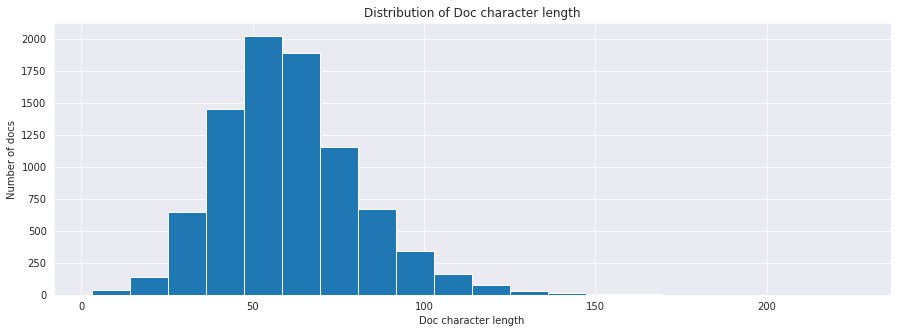

In [3]:
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))

fig = plt.figure(figsize=(15, 5))

doc_lens = [len(d) for d in df.clean]

plt.hist(doc_lens, bins = 20)
plt.title('Distribution of Doc character length')
plt.ylabel('Number of docs')
plt.xlabel('Doc character length')
plt.show()

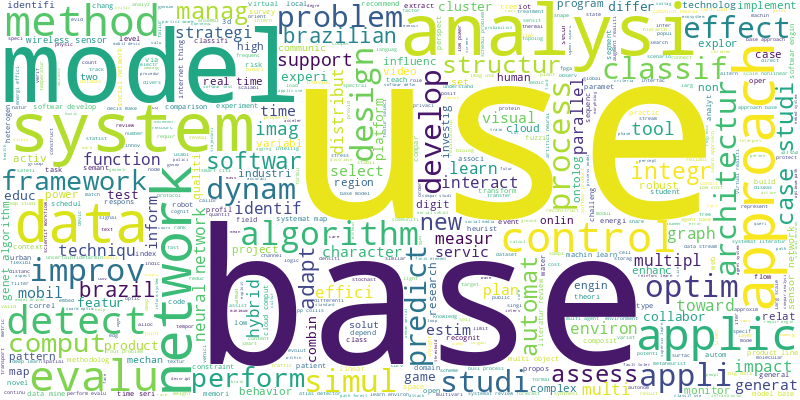

In [4]:
long_string = ' '.join(list(df['clean'].values))

wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color="white",
                max_words=5000,
                contour_width=3,
                contour_color='steelblue'
                ).generate(long_string)

wordcloud.to_image()

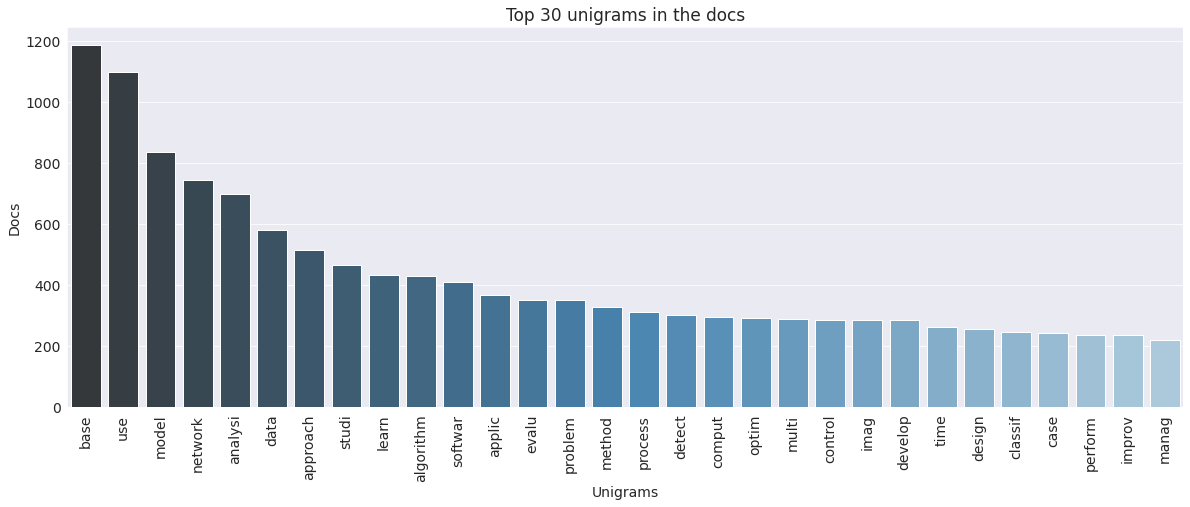

In [5]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = plt.figure(figsize=(20,7))

x = df2['unigram']
y = df2['count']

g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='Blues_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Unigrams', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Top 30 unigrams in the docs', fontsize=17)

plt.show()
del df2

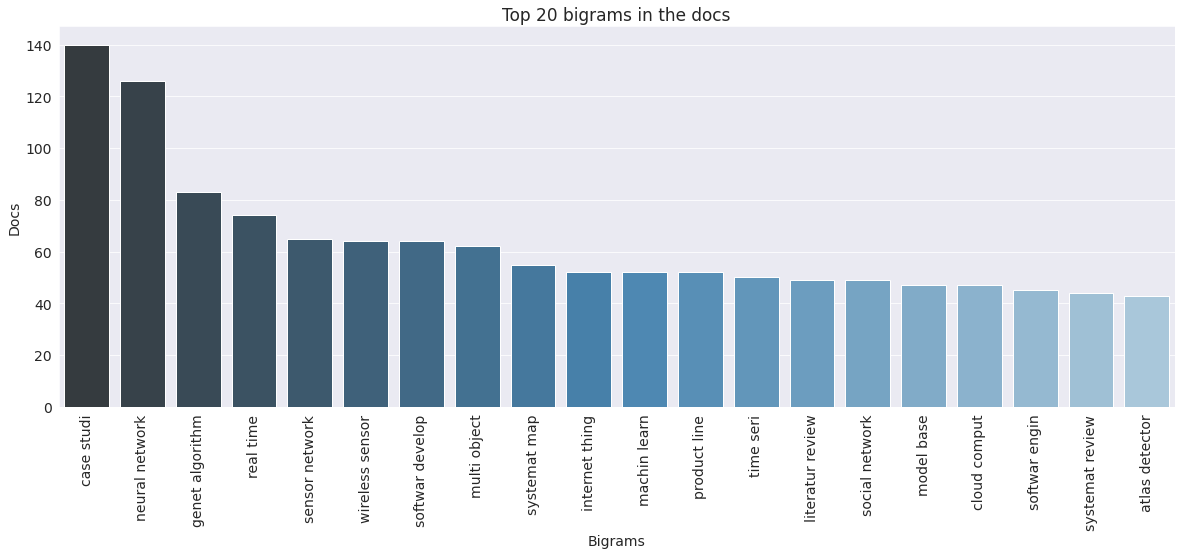

In [6]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = plt.figure(figsize=(20,7))

x = df3['bigram']
y = df3['count']

g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='Blues_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Top 20 bigrams in the docs', fontsize=17)

plt.show()
del df3

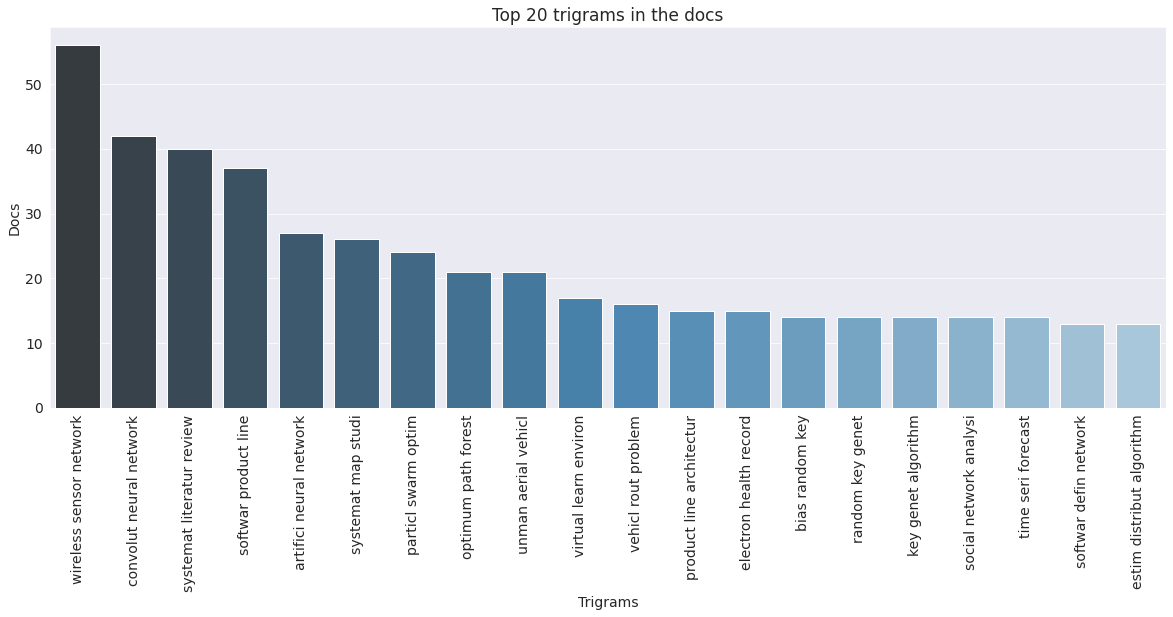

In [7]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['clean'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = plt.figure(figsize=(20,7))

x = df4['trigram']
y = df4['count']

g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='Blues_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Trigrams', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Top 20 trigrams in the docs', fontsize=17)

plt.show()
del df4

In [25]:
vectorizer = CountVectorizer(
    min_df=0.005,
    max_df=0.9,
    analyzer='word',
    stop_words='english',
    lowercase=True,
    token_pattern='[a-zA-Z0-9]{3,}',
    ngram_range=(1,2),
    max_features=5000)

data_vectorized = vectorizer.fit_transform(df['clean'])

lda_model = LatentDirichletAllocation(
    n_components=20, # Number of topics
    learning_method='online',
    random_state=0,
    n_jobs = -1) # Use all available CPUs

lda_output = lda_model.fit_transform(data_vectorized)

In [26]:
ldavis = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(ldavis, './docs/LDA-modeling.html')
pyLDAvis.display(ldavis)

In [27]:
# print log-likelihood
print("Log likelihood: ", lda_model.score(data_vectorized))

# print perplexity
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log likelihood:  -235991.4154270108
Perplexity:  387.0782332025748


In [28]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['W'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['T'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19
T0,model,estim,use,search,variabl,associ,patient,investig,water,paramet,intellig,evolut,correl,forecast,respons,differenti,locat,empir,test,cluster
T1,analysi,measur,energi,high,graph,social,compar,network,extract,databas,hevc,urban,social network,determin,base,applic,video,studi,artifici,comput
T2,studi,improv,distribut,video,robot,task,chang,oper,autonom,tempor,transform,profil,region,methodolog,risk,content,reliabl,manag,onlin,brazil
T3,virtual,low,use,scale,combin,segment,enhanc,cost,filter,set,state,match,detector,transfer,atlas,natur,realiti,protocol,game,genet
T4,approach,product,brazil,project,linear,line,softwar,user,knowledg,diseas,comparison,build,use,cell,heterogen,product line,spatial,assist,uncertainti,construct
T5,network,develop,techniqu,visual,sensor,softwar,wireless,smart,research,identifi,use,theori,dimension,survey,internet,softwar develop,busi,sensor network,wireless sensor,thing
T6,new,interact,base,cluster,complex,ontolog,character,level,decis,human,flow,onlin,detect,semant,class,network,approach,communiti,artifici,use
T7,imag,classif,brazilian,base,featur,select,use,path,recognit,languag,domain,forest,recommend,solut,classifi,approach,ensembl,distanc,semi,index
T8,data,map,network,dynam,function,use,neural,inform,neural network,open,tree,pattern,stream,approach,composit,analyt,systemat map,systemat,point,convolut
T9,process,applic,evalu,design,test,awar,collabor,activ,industri,experiment,fault,diagnosi,text,physic,organ,evolutionari,environ,base,model,robot
